In [2]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score


### Load data

In [3]:
dataset = pd.read_parquet(r"C:\Users\druzh\Project_python\ozon_top_1\Datasets/test_pairs_wo_target.parquet")
etl = pd.read_parquet(r"C:\Users\druzh\Project_python\ozon_top_1\Datasets/test_data.parquet")

Get raw data for each variantid.

In [4]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [5]:
features.head(2)

,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,52076340,290590137,Батарейка AAA щелочная Perfeo LR03/10BL Super ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[0.15417035, 0.41160947, 0.2213532, -0.019731...","[[0.04763528, -0.20136409, 0.29605597, 0.26453...","[-0.28437558, 0.60909724, 0.5972025, -0.523296...","{""Напряжение, В"":[""1.5""],""Бренд"":[""Perfeo""],""Т...",Батарейка AAA щелочная Perfeo LR03/2BL mini Su...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[-0.025554053, 0.012488857, 0.43989864, -0.10...","[[0.06223978, -0.16145544, 0.26409012, 0.24271...","[-0.3380968, 0.6156224, 0.6428071, -0.57499236...","{""Форм-фактор батареи"":[""AAA""],""Химический тип..."
1,64525522,204128919,"Смартфон Ulefone Armor X5 3/32 ГБ, черный, кра...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, red, красный]","[[-0.239386, -0.8332473, -0.08384809, 0.071721...","[[-0.27325493, -0.6696304, 0.027148303, 0.0785...","[-0.45766184, 0.5528555, 0.26298037, -0.663931...","{""Операционная система"":[""Android""],""Защищенно...","Смартфон Ulefone Armor X3 2/32 ГБ, черный, кра...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, red, красный]","[[-0.071279265, -0.99063504, -0.3939417, 0.886...","[[-0.15358369, -0.8256463, -0.054863703, 0.453...","[-0.4489074, 0.6278857, 0.33072582, -0.6749875...","{""Встроенная память"":[""32 ГБ""],""Видеопроцессор..."


In [6]:
features['main_pic_embeddings_resnet_v11'].values[0][0]

array([ 0.04763528, -0.20136409,  0.29605597,  0.2645368 ,  0.51119983,
        0.60018665,  0.19552247, -0.4333941 , -0.49884683,  0.38784367,
        0.5703227 , -0.25018132,  0.6071745 , -0.12079154,  0.99341345,
       -0.30498552,  0.20273238,  0.12454182, -0.042265  ,  0.577005  ,
       -0.24721067,  0.6735559 , -0.3903222 ,  0.01059844, -0.65675026,
        1.0700275 , -0.02793022,  0.23005718,  0.65905595, -0.67685944,
       -0.11092377, -0.07732415,  0.12085689,  0.39240903,  0.8216982 ,
        0.00681859, -0.7240758 ,  1.2317172 , -0.00535129,  0.78719115,
       -0.9324111 , -0.729403  ,  0.42084643,  0.08476207,  0.47978467,
        0.02893776, -0.9612635 , -0.6898223 ,  0.52903855, -0.03765219,
       -0.07191771, -0.5460057 ,  0.07444818, -0.36412084,  0.12952298,
        0.27745754,  0.75014544, -0.00905189,  0.90505326, -0.12536295,
        0.5339691 ,  0.6478877 , -0.59209216, -0.47688907,  0.22894141,
       -0.7365148 ,  0.7758063 ,  0.39492857,  0.3653146 , -0.15

In [7]:
embeddings = []
for i in features['main_pic_embeddings_resnet_v11'].values:
    embeddings.append(i[0])

In [8]:
embeddings = np.array(embeddings)

In [9]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=3, perplexity=30, learning_rate=200)

compressed_embeddings_main_pic = tsne_model.fit_transform(embeddings)

In [10]:
name_bert_641_embedding = np.array(features['name_bert_641'].values)

In [11]:
name_bert_641_embedding

array([array([-0.28437558,  0.60909724,  0.5972025 , -0.5232965 ,  0.7563308 ,
               0.47082475, -0.2672505 , -0.4942717 ,  0.58855546, -0.58698857,
              -0.7618906 ,  0.43330786,  0.49224737, -0.33724326,  0.589526  ,
               0.47093964,  0.53254056,  0.29769692,  0.6021944 , -0.52584225,
               0.27330077, -0.47123113,  0.6675562 , -0.6776218 , -0.5503898 ,
              -0.4947149 , -0.37133807, -0.5677406 ,  0.5409019 , -0.5887402 ,
              -0.580144  ,  0.75837916, -0.5580442 , -0.08127583,  0.46075657,
               0.01953361,  0.2757493 , -0.6743602 ,  0.40045843,  0.6485307 ,
               0.44278628,  0.5400431 ,  0.47197998, -0.62950945, -0.5059172 ,
              -0.22513512, -0.68574995,  0.626803  , -0.30935547, -0.7325441 ,
              -0.3603546 ,  0.43958068,  0.23849213,  0.06470592,  0.37669367,
              -0.5074474 ,  0.5999005 ,  0.50383866, -0.32925478, -0.29172146,
              -0.05056638,  0.2956777 ,  0.69035864,

In [12]:
name_bert_641_embedding = []
for i in features['name_bert_641'].values:
    name_bert_641_embedding.append(i)

In [13]:
name_bert_641_embedding_final = np.array(name_bert_641_embedding)

In [14]:
tsne_model = TSNE(n_components=3, perplexity=30, learning_rate=200)

compressed_embeddings_name_bert_641 = tsne_model.fit_transform(name_bert_641_embedding_final)

In [15]:
embeddings_main_2 = []
for i in features['main_pic_embeddings_resnet_v12'].values:
    embeddings_main_2.append(i[0])

In [16]:
embeddings_main_2_final = np.array(embeddings_main_2)

In [17]:
tsne_model = TSNE(n_components=3, perplexity=30, learning_rate=200)

compressed_embeddings_main_pic_2 = tsne_model.fit_transform(embeddings_main_2_final)

In [18]:
name_bert_642_embedding = []
for i in features['name_bert_642'].values:
    name_bert_642_embedding.append(i)

In [19]:
name_bert_642_embedding_final = np.array(name_bert_642_embedding)

In [20]:
tsne_model = TSNE(n_components=3, perplexity=30, learning_rate=200)

compressed_embeddings_name_bert_642 = tsne_model.fit_transform(name_bert_642_embedding_final)

In [15]:
feats = ["main_pic_embeddings_resnet_v11", "name_bert_641", "main_pic_embeddings_resnet_v12", "name_bert_642"]

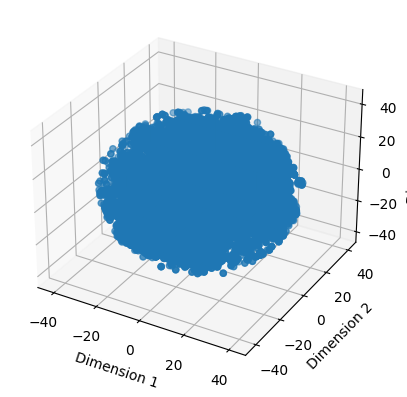

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(compressed_embeddings_name_bert_641[:, 0], compressed_embeddings_name_bert_641[:, 1], compressed_embeddings_name_bert_641[:, 2])

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

plt.show()

In [22]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2"]], 
    test_size=0.1, random_state=42, stratify=features[["target"]])

y_test = X_test[["target"]]
X_test = X_test.drop(["target", "variantid1", "variantid2"], axis=1)

y_train = X_train["target"]
X_train = X_train.drop(["target","variantid1", "variantid2"], axis=1)

NameError: name 'feats' is not defined

In [23]:
print(X_train.shape)

NameError: name 'X_train' is not defined

In [24]:
print(X_test.shape)

NameError: name 'X_test' is not defined

Features functions.

In [25]:
X_train_final = []

for i in range(len(X_train)):
    row = []
    row.extend(list(X_train[feats[0]].iloc[i])[0])
    row.extend(list(X_train[feats[1]].iloc[i]))
    row.extend(list(X_train[feats[2]].iloc[i])[0])
    row.extend(list(X_train[feats[3]].iloc[i]))
    X_train_final.append(row)

In [26]:
X_test_final = []

for i in range(len(X_test)):
    row = []
    row.extend(list(X_test[feats[0]].iloc[i])[0])
    row.extend(list(X_test[feats[1]].iloc[i]))
    row.extend(list(X_test[feats[2]].iloc[i])[0])
    row.extend(list(X_test[feats[3]].iloc[i]))
    X_test_final.append(row)

In [33]:
from catboost import CatBoostClassifier
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
        'border_count': trial.suggest_int('border_count', 5, 255),
        'random_seed': 42,
        'eval_metric': 'Accuracy',
        'loss_function': 'Logloss',
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train_final, y_train, eval_set=(X_test_final, y_test), early_stopping_rounds=20, verbose=False)
    y_pred = model.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Создание объекта study и запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Получение лучших параметров
best_params = study.best_params
best_accuracy = study.best_value

print('Best parameters:', best_params)
print('Best accuracy:', best_accuracy)

[I 2023-05-25 20:04:50,080] A new study created in memory with name: no-name-553ed098-fe03-4bf4-bcea-9f9bb9ac04b0
C:\Users\druzh\AppData\Local\Temp\ipykernel_9680\40164566.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\druzh\AppData\Local\Temp\ipykernel_9680\40164566.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
[I 2023-05-25 20:06:19,139] Trial 0 finished with value: 0.7688066810204215 and parameters: {'iterations': 772, 'learning_rate': 0.4006577177062766, 'depth': 9, 'l2_leaf_reg': 3.9

[I 2023-05-25 20:18:05,374] Trial 8 finished with value: 0.7368369543942063 and parameters: {'iterations': 882, 'learning_rate': 0.022525843063157382, 'depth': 6, 'l2_leaf_reg': 5.253986073515961, 'border_count': 41}. Best is trial 4 with value: 0.7712859659424545.
C:\Users\druzh\AppData\Local\Temp\ipykernel_9680\40164566.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\druzh\AppData\Local\Temp\ipykernel_9680\40164566.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
[I 2023-05-25 20:19:14,921]

[I 2023-05-25 20:39:25,409] Trial 17 finished with value: 0.7684152149801005 and parameters: {'iterations': 973, 'learning_rate': 0.05904781409398694, 'depth': 8, 'l2_leaf_reg': 0.5107036424817228, 'border_count': 151}. Best is trial 11 with value: 0.7715795654726952.
C:\Users\druzh\AppData\Local\Temp\ipykernel_9680\40164566.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\druzh\AppData\Local\Temp\ipykernel_9680\40164566.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
[I 2023-05-25 20:43:08,5

Best parameters: {'iterations': 517, 'learning_rate': 0.047054063568355974, 'depth': 10, 'l2_leaf_reg': 0.11683807614991185, 'border_count': 75}
Best accuracy: 0.7715795654726952


In [34]:
model = CatBoostClassifier(iterations = 517, learning_rate = 0.047054063568355974, depth = 10, l2_leaf_reg = 0.11683807614991185, border_count = 75)

model.fit(X_train_final, y_train)

0:	learn: 0.6813710	total: 338ms	remaining: 2m 54s
1:	learn: 0.6707417	total: 706ms	remaining: 3m 1s
2:	learn: 0.6612430	total: 1.06s	remaining: 3m 2s
3:	learn: 0.6520319	total: 1.42s	remaining: 3m 1s
4:	learn: 0.6432654	total: 1.79s	remaining: 3m 3s
5:	learn: 0.6359395	total: 2.14s	remaining: 3m 2s
6:	learn: 0.6297434	total: 2.5s	remaining: 3m 1s
7:	learn: 0.6234839	total: 2.85s	remaining: 3m 1s
8:	learn: 0.6180071	total: 3.19s	remaining: 3m
9:	learn: 0.6124650	total: 3.54s	remaining: 2m 59s
10:	learn: 0.6078602	total: 3.88s	remaining: 2m 58s
11:	learn: 0.6031106	total: 4.25s	remaining: 2m 58s
12:	learn: 0.5987036	total: 4.61s	remaining: 2m 58s
13:	learn: 0.5948262	total: 4.98s	remaining: 2m 58s
14:	learn: 0.5913396	total: 5.32s	remaining: 2m 58s
15:	learn: 0.5876569	total: 5.68s	remaining: 2m 57s
16:	learn: 0.5846856	total: 6.02s	remaining: 2m 57s
17:	learn: 0.5818373	total: 6.38s	remaining: 2m 56s
18:	learn: 0.5790497	total: 6.74s	remaining: 2m 56s
19:	learn: 0.5762778	total: 7.12s	

158:	learn: 0.4780781	total: 59.5s	remaining: 2m 13s
159:	learn: 0.4777643	total: 59.8s	remaining: 2m 13s
160:	learn: 0.4774162	total: 1m	remaining: 2m 13s
161:	learn: 0.4770484	total: 1m	remaining: 2m 12s
162:	learn: 0.4766932	total: 1m	remaining: 2m 12s
163:	learn: 0.4764083	total: 1m 1s	remaining: 2m 11s
164:	learn: 0.4760485	total: 1m 1s	remaining: 2m 11s
165:	learn: 0.4756932	total: 1m 2s	remaining: 2m 11s
166:	learn: 0.4753714	total: 1m 2s	remaining: 2m 10s
167:	learn: 0.4749979	total: 1m 2s	remaining: 2m 10s
168:	learn: 0.4746559	total: 1m 3s	remaining: 2m 10s
169:	learn: 0.4743303	total: 1m 3s	remaining: 2m 9s
170:	learn: 0.4740349	total: 1m 3s	remaining: 2m 9s
171:	learn: 0.4736662	total: 1m 4s	remaining: 2m 8s
172:	learn: 0.4733699	total: 1m 4s	remaining: 2m 8s
173:	learn: 0.4730145	total: 1m 4s	remaining: 2m 8s
174:	learn: 0.4727385	total: 1m 5s	remaining: 2m 7s
175:	learn: 0.4724727	total: 1m 5s	remaining: 2m 7s
176:	learn: 0.4721149	total: 1m 6s	remaining: 2m 6s
177:	learn

311:	learn: 0.4326589	total: 1m 55s	remaining: 1m 15s
312:	learn: 0.4324203	total: 1m 55s	remaining: 1m 15s
313:	learn: 0.4321352	total: 1m 56s	remaining: 1m 15s
314:	learn: 0.4318723	total: 1m 56s	remaining: 1m 14s
315:	learn: 0.4315714	total: 1m 57s	remaining: 1m 14s
316:	learn: 0.4312535	total: 1m 57s	remaining: 1m 14s
317:	learn: 0.4310168	total: 1m 57s	remaining: 1m 13s
318:	learn: 0.4307031	total: 1m 58s	remaining: 1m 13s
319:	learn: 0.4304347	total: 1m 58s	remaining: 1m 12s
320:	learn: 0.4302003	total: 1m 58s	remaining: 1m 12s
321:	learn: 0.4299433	total: 1m 59s	remaining: 1m 12s
322:	learn: 0.4296804	total: 1m 59s	remaining: 1m 11s
323:	learn: 0.4294209	total: 2m	remaining: 1m 11s
324:	learn: 0.4291834	total: 2m	remaining: 1m 11s
325:	learn: 0.4289126	total: 2m	remaining: 1m 10s
326:	learn: 0.4286651	total: 2m 1s	remaining: 1m 10s
327:	learn: 0.4284163	total: 2m 1s	remaining: 1m 10s
328:	learn: 0.4281838	total: 2m 1s	remaining: 1m 9s
329:	learn: 0.4279331	total: 2m 2s	remaining

467:	learn: 0.3942137	total: 2m 53s	remaining: 18.2s
468:	learn: 0.3940023	total: 2m 53s	remaining: 17.8s
469:	learn: 0.3937752	total: 2m 54s	remaining: 17.4s
470:	learn: 0.3935683	total: 2m 54s	remaining: 17.1s
471:	learn: 0.3933421	total: 2m 55s	remaining: 16.7s
472:	learn: 0.3931428	total: 2m 55s	remaining: 16.3s
473:	learn: 0.3929225	total: 2m 55s	remaining: 15.9s
474:	learn: 0.3926973	total: 2m 56s	remaining: 15.6s
475:	learn: 0.3924986	total: 2m 56s	remaining: 15.2s
476:	learn: 0.3922794	total: 2m 56s	remaining: 14.8s
477:	learn: 0.3920828	total: 2m 57s	remaining: 14.5s
478:	learn: 0.3918566	total: 2m 57s	remaining: 14.1s
479:	learn: 0.3916466	total: 2m 58s	remaining: 13.7s
480:	learn: 0.3914239	total: 2m 58s	remaining: 13.3s
481:	learn: 0.3912163	total: 2m 58s	remaining: 13s
482:	learn: 0.3909786	total: 2m 59s	remaining: 12.6s
483:	learn: 0.3907540	total: 2m 59s	remaining: 12.2s
484:	learn: 0.3905109	total: 2m 59s	remaining: 11.9s
485:	learn: 0.3903243	total: 3m	remaining: 11.5s

In [35]:
import random

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
prediction = model.predict(X_test_final)

mse = mean_squared_error(y_test, prediction)
print("Mean Squared Error:", mse)

f1 = f1_score(y_test, prediction)
print("f1:", f1)

accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Mean Squared Error: 0.228779278397599
f1: 0.7353085487827892
Accuracy: 0.771220721602401
Precision: 0.7496536863167615
Recall: 0.7215021109547441


In [36]:
model.save_model("catboost_with_embs_only_optune_epochs.cbm")